# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook, describes how I built the Traffic sign Classifier.

---
## Step 0: Load The Data
At first we will need to load the data from the pickle files.
The file `signnames.csv` contains id -> name mappings for each id.

The pickled data is a dictionary with 4 key/value pairs, I listed here the two used key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign.


In [1]:
# Load pickled data
import os
import pickle


training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

augmented_file = 'data/augmentedTrain.p'
if not os.path.isfile(augmented_file):
    print("Loading ", training_file)
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
else:
    print("Loading ", augmented_file)
    with open(augmented_file, mode='rb') as f:
        train = pickle.load(f)
        
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


Loading  data/train.p


---

## Step 1: Dataset Summary & Exploration

I used the numpy library to calculate summary statistics of the traffic
signs data set

### A Basic Summary of the Data Set

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("The size of the training set =", n_train)
print("The size of the validation set =", n_validation)
print("The size of the testing set =", n_test)
print("The shape of a traffic sign image =", image_shape)
print("The number of unique classes/labels in the data set =", n_classes)

The size of the training set = 34799
The size of the validation set = 4410
The size of the testing set = 12630
The shape of a traffic sign image = (32, 32, 3)
The number of unique classes/labels in the data set = 43


### Visualization of the dataset

Here i plot a grapth representing number of sample for each class, then i visualize a sample of each class in the data set.

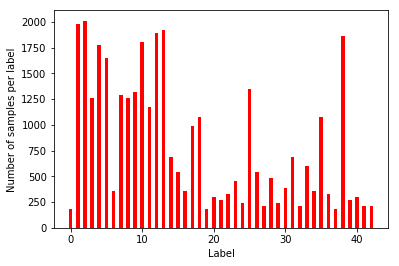

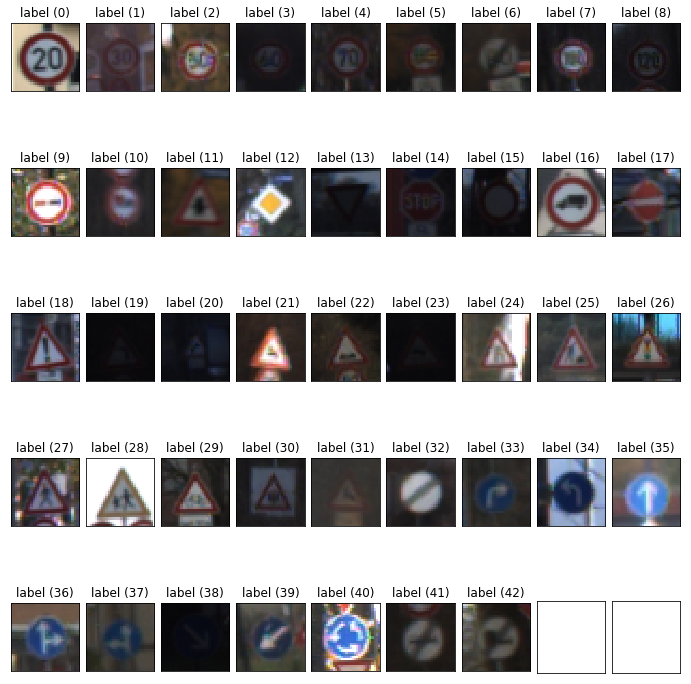

In [3]:
### Data exploration visualization code goes here.
import matplotlib.pyplot as plt

if not os.path.isfile(augmented_file):
    # Visualizations will be shown in the notebook.
    %matplotlib inline

    fig, ax = plt.subplots()
    x,indexs,number_of_samples = np.unique(y_train,return_counts = True,return_index=True)
    ax.bar(x, number_of_samples, .5, color='r')
    ax.set_xlabel('Label')
    ax.set_ylabel('Number of samples per label')

    fig, axes = plt.subplots(5, 9, figsize=(12, 12),
                             subplot_kw={'xticks': [], 'yticks': []})

    fig.subplots_adjust(hspace=1, wspace=0.1)

    for ax, index in zip(axes.flat, indexs):
        ax.imshow(X_train[index])
        ax.set_title("label ({})".format(y_train[index]))

    plt.show()



### Data Augmentation
It's clear from the Bar chart that there is a big difference between the number of samples for each class. To solve this issue I'll introduce a data augmentation step to increase number of samples for classes with less than 1000 samples.

In [4]:
import cv2
def augment_image(image):
    distorted_image = image
    
    # apply random rotation on the image
    angle = np.random.randint(-20,20)
    M = cv2.getRotationMatrix2D((16,16),angle,1)
    distorted_image = cv2.warpAffine(distorted_image,M,(32,32))
    
    # apply an image translation in Raws and Cols
    x_shift = np.random.randint(5)
    y_shift = np.random.randint(5)
    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    distorted_image = cv2.warpAffine(distorted_image,M,(32,32))
    
    # apply random contast adjust
    Contrast_ratio = float(np.random.randint(2,18)) / 10
    distorted_image = distorted_image * Contrast_ratio 
    distorted_image = distorted_image.astype(np.uint8)
      
    return distorted_image

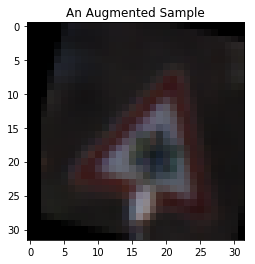

In [5]:
if not os.path.isfile(augmented_file): 
    # get the list of labels with number of samples less than 1000
    small_samples_indices = [i for i, samples_count in enumerate(number_of_samples) if samples_count < 1000]

    # get the indices of all data samples to be augmented
    indices_for_augmentation = [i for i, datalabel in enumerate(y_train) if datalabel in small_samples_indices]

    # get the list of data samples to be augmented
    samples_for_augmentation = X_train[indices_for_augmentation]

    # get the list of labels for data samples to be augmented
    labels_for_augmentation = y_train[indices_for_augmentation]

    data_range = len(samples_for_augmentation)

    augmented_samples = []
    for i in range(data_range):
        augmented_samples.append(augment_image(samples_for_augmentation[i]))

    sample_index = np.random.randint(data_range)
    plt.imshow(augmented_samples[sample_index])
    plt.title("An Augmented Sample")

Now as our Augmented samples are ready. I will add them to our training dataset

In [6]:
if not os.path.isfile(augmented_file):
    X_train = np.concatenate((X_train,augmented_samples),axis=0)
    y_train = np.concatenate((y_train,labels_for_augmentation),axis=0)

Let's now see some statestics on our new data set

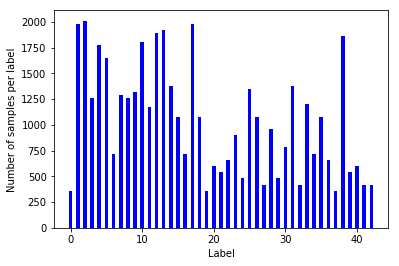

In [7]:
fig, ax = plt.subplots()
x,indexs,y = np.unique(y_train,return_counts = True,return_index=True)
ax.bar(x, y, .5, color='b')
ax.set_xlabel('Label')
ax.set_ylabel('Number of samples per label')

As my data augmentation stack is based on randomization.I'll save my new Dataset in a pickle file to load it later. To make sure that I train my model with the same dataset each time.

In [8]:
# Save the data for easy access
if not os.path.isfile(augmented_file):
    print('Saving data to pickle file...')
    try:
        with open(augmented_file, 'wb') as pfile:
            pickle.dump(
                {
                    'features': X_train,
                    'labels': y_train,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
    print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


----

## Step 2: Design and Test a Model Architecture


### Pre-process the Data Set (normalization, grayscale, etc.)

**This is the preprocessing functions I've used. I'll present the effect of each step in the up comming section**

In [9]:
from sklearn.utils import shuffle
import cv2

def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    return (a + (image_data)*(b - a)/255)

def histogram_equalize(img):
    """Applies histogram equalization on the input image
    :img: image to be equalized
    :return: equalized image"""
    return cv2.equalizeHist(img)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def preprocess_data(data):
    preprocessed_data = []
    for image in data:
        image = grayscale(image)
        image = histogram_equalize(image)
        image = normalize_grayscale(image)
        preprocessed_data.append(image)
    return preprocessed_data

Let's select a random image from the data set to visualize it before and after each preprocessing step

In [10]:
random_image_index = np.random.randint(len(X_train))

Original Image shape is  (32, 32, 3)


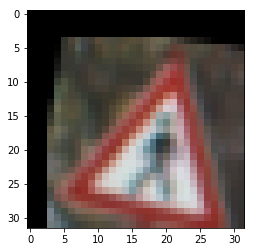

In [11]:
original_image = X_train[random_image_index]
print("Original Image shape is ",original_image.shape)
plt.imshow(original_image)

The first step I have done is to convert my images into gray scale to reduce the network's complexity by having only one color channel.

Gray scaled Image shape is  (32, 32)


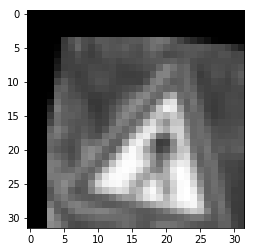

In [12]:
gray_scaled_image = grayscale(original_image)
print("Gray scaled Image shape is ",gray_scaled_image.shape)
plt.imshow(gray_scaled_image,cmap='gray')

Now we can see that the image is dark. Histogram Equalization will balance the colors in the Image to make Image features more clear.

Histogram Equalized Image shape is  (32, 32)


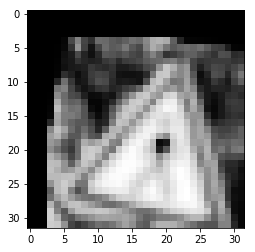

In [13]:
histogram_equalized_image = histogram_equalize(gray_scaled_image)
print("Histogram Equalized Image shape is ",histogram_equalized_image.shape)
plt.imshow(histogram_equalized_image,cmap='gray')

Finally, the image data is normalized so that the data has mean zero and equal variance.

In [14]:
normalized_image = normalize_grayscale(histogram_equalized_image)

Now as we have seen the effect of each single step in the preprocessing, I'll use **preprocess_data()** function to perform the preprocessing for Training,Validation and Test data sets.

In [15]:
X_train = preprocess_data(X_train)
X_valid = preprocess_data(X_valid)
X_test = preprocess_data(X_test)

Now let's have another look on the same sample images after preprocessing

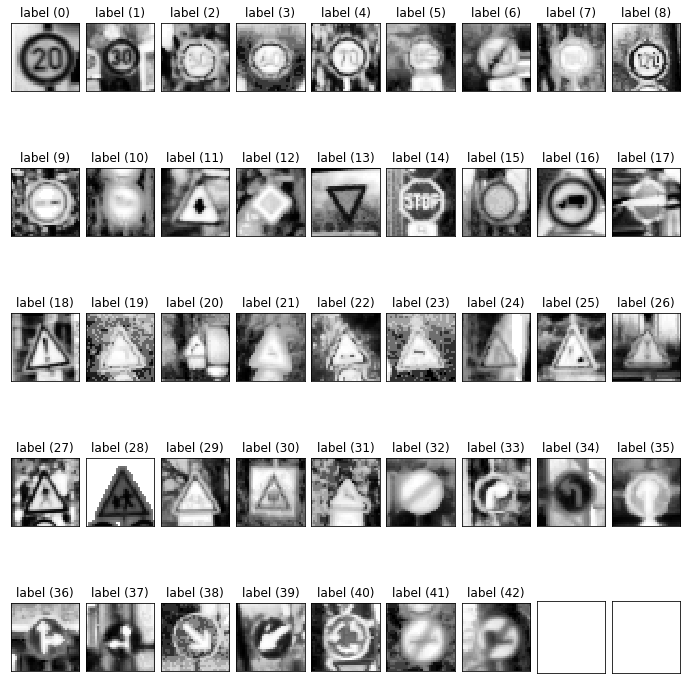

In [16]:
fig, axes = plt.subplots(5, 9, figsize=(12, 12),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=1, wspace=0.1)

for ax, index in zip(axes.flat, indexs):
    ax.imshow(X_train[index],cmap='gray')
    ax.set_title("label ({})".format(y_train[index]))

### Model Architecture

My Model's architecture is LeNet Architecture as follows:
![png](LeNet.png)

| Layer         		|     Description	        					| 
|:---------------------:|:---------------------------------------------:| 
| Input         		| 32x32x1 Gray image   							| 
| Convolution 5x5     	| 1x1 stride, VALID padding, outputs 28x28x6 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  VALID padding, outputs 14x14x6	|
| Convolution 5x5	    | 1x1 stride, VALID padding, outputs 10x10x16 	|
| RELU					|												|
| Max pooling	      	| 2x2 stride,  VALID padding, outputs 5x5x16    |
| Flatten				| outputs 400									|
| Fully connected		| Outputs  120									|
| RELU					|												|
| Dropout				|												|
| Fully connected		| Outputs  84									|
| RELU					|												|
| Dropout				|												|
| Fully connected		| Outputs  43									|


Basically I added two dropout steps at the output of layers 3 and 4 to improve the network's performance.

In [17]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from numpy import array

def LeNet(x,keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits,conv1,conv2

Now let's create TensorFlow placeholders and set our hyperparameters.
Basically as i added two dropout steps i need to create the **keep_prob** placeholder.

I also created the One_Hot for the my labels.

For BATCH_SIZE i selected 128 as i have a relatively big Memory to load data in.

For the learning rate 0.001 is a typical good initial value

My first trial was using EPOCHs = 20, later i decided to increase it to 40 to get better training in my network.

In [18]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)
EPOCHS = 40
BATCH_SIZE = 128
rate = 0.001

For the Optimizer i selected **AdamOptimizer** as it uses Kingma and Ba's Adam algorithm to control the learning rate. Adam offers several advantages over the simple SGD. Foremost is that it uses moving averages of the parameters, this enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning.

In [19]:
logits,conv1,conv2 = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Finally, here is the code segment to calculate model accuracy. I'll use it with Validation and Test datasets. Later on I'll use it with my new Images.

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train, Validate and Test the Model

In the next step we will train the model and then save it.

#### Train the model

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    X_valid = np.expand_dims(X_valid, axis=3)
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            batch_x = np.expand_dims(batch_x, axis=3)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5})
            
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.590

EPOCH 2 ...
Validation Accuracy = 0.745

EPOCH 3 ...
Validation Accuracy = 0.795

EPOCH 4 ...
Validation Accuracy = 0.827

EPOCH 5 ...
Validation Accuracy = 0.853

EPOCH 6 ...
Validation Accuracy = 0.863

EPOCH 7 ...
Validation Accuracy = 0.882

EPOCH 8 ...
Validation Accuracy = 0.898

EPOCH 9 ...
Validation Accuracy = 0.901

EPOCH 10 ...
Validation Accuracy = 0.912

EPOCH 11 ...
Validation Accuracy = 0.916

EPOCH 12 ...
Validation Accuracy = 0.919

EPOCH 13 ...
Validation Accuracy = 0.917

EPOCH 14 ...
Validation Accuracy = 0.937

EPOCH 15 ...
Validation Accuracy = 0.930

EPOCH 16 ...
Validation Accuracy = 0.927

EPOCH 17 ...
Validation Accuracy = 0.926

EPOCH 18 ...
Validation Accuracy = 0.924

EPOCH 19 ...
Validation Accuracy = 0.935

EPOCH 20 ...
Validation Accuracy = 0.936

EPOCH 21 ...
Validation Accuracy = 0.944

EPOCH 22 ...
Validation Accuracy = 0.944

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

Great! Now as Validation Accuracy is greater than 0.93, let's Test our model on the Test dataset.

#### Evaluate the model

In [22]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    X_test = np.expand_dims(X_test, axis=3)
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.926


---

## Step 3: Test a Model on New Images

Now let's try our model on 5 new images from the internet. All images i could find on the internet had big resolutions. I performed some manual cropping on the images to make it 32x32. Cropped images are saved in **'images/'** folder.

### Load the CSV file of Sign Names

In [23]:
import csv
sign_names_dict = {}
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for i in reader:
        sign_names_dict[i[0]]=i[1]

### Load and Output the Images

In [24]:
from os import listdir
from os.path import isfile, join
import cv2

files = [f for f in listdir('images/') if isfile(join('images/', f))]

images = []
labels = []
for file in files:
    image = cv2.imread(join('images/', file),-1)
    label = file.split('_')[0]
    images.append(image)
    labels.append(label)
images = preprocess_data(images)

Now let's visualize the data

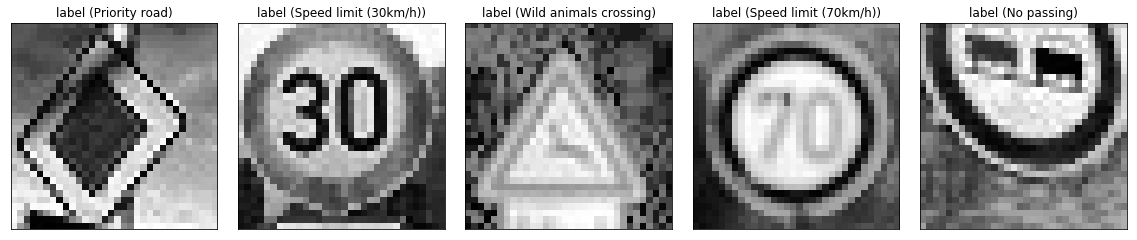

In [25]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=2, wspace=0.1)

for ax, image,label in zip(axes.flat, images,labels):
    ax.imshow(image,cmap='gray')
    ax.set_title("label ({})".format(sign_names_dict[label]))


### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from .\lenet


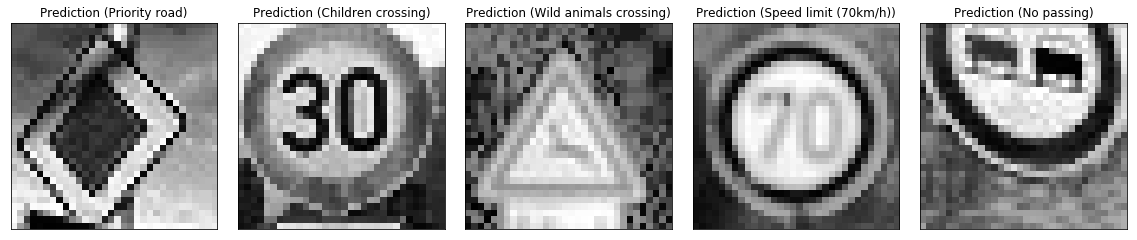

In [26]:
def getPrediction(X_data):
    num_examples = len(X_data)
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        batch_x = np.expand_dims(X_data, axis=3)
        predictions = sess.run(logits, feed_dict={x: batch_x, keep_prob : 1})
        top5_predictions = sess.run(tf.nn.top_k(predictions, k=5))
        predictions = sess.run(tf.argmax(predictions, 1))
    return predictions,top5_predictions

predictions, top5_predictions = getPrediction(images)


fig, axes = plt.subplots(1, 5, figsize=(20, 20),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=2, wspace=0.1)

for ax, image,label in zip(axes.flat, images,predictions):
    ax.imshow(image,cmap='gray')
    ax.set_title("Prediction ({})".format(sign_names_dict[str(label)]))

### Analyze Performance

In [27]:
### Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    batch_x = np.expand_dims(images, axis=3)
    test_accuracy = evaluate(batch_x, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, we print out the model's softmax probabilities to show the **certainty** of the model's predictions

In [28]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
print(top5_predictions)

for i in range(5):
    print("\nTop 5 predections for image {} are :".format(i))
    for j in range(5):
        print("\n\t{} : {}".format(top5_predictions[1][i][j],sign_names_dict[str(top5_predictions[1][i][j])]))

TopKV2(values=array([[ 15.89681911,   3.26698732,   2.19370675,  -1.39770448,
         -2.52430511],
       [  1.08917642,   0.09917483,  -0.08225614,  -0.36001211,  -0.3770729 ],
       [ 20.27925301,  13.74192619,   7.26025438,   5.78252125,
          3.65648985],
       [ 18.05321884,  10.17467117,   9.63263226,   6.05646133,
          5.48789978],
       [ 13.47514534,  12.9828043 ,   9.86765003,   6.07638073,
          4.77030754]], dtype=float32), indices=array([[12, 42, 41, 40, 13],
       [28, 24, 30, 29, 31],
       [31, 21, 23, 19, 29],
       [ 4,  7,  8,  1, 39],
       [ 9, 13, 10, 42, 41]]))

Top 5 predections for image 0 are :

	12 : Priority road

	42 : End of no passing by vehicles over 3.5 metric tons

	41 : End of no passing

	40 : Roundabout mandatory

	13 : Yield

Top 5 predections for image 1 are :

	28 : Children crossing

	24 : Road narrows on the right

	30 : Beware of ice/snow

	29 : Bicycles crossing

	31 : Wild animals crossing

Top 5 predections for image 2

---

## Step 4 : Visualize the Neural Network's State with Test Images

 We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training our neural network we can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.


In [29]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        image_extended = np.expand_dims(image_input, axis=0)
        image_extended = np.expand_dims(image_extended, axis=3)
        activation = tf_activation.eval(session=sess,feed_dict={x : image_extended})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from .\lenet


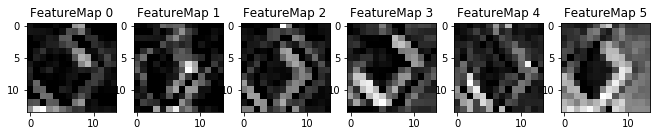

In [30]:
outputFeatureMap(images[0],conv1)

INFO:tensorflow:Restoring parameters from .\lenet


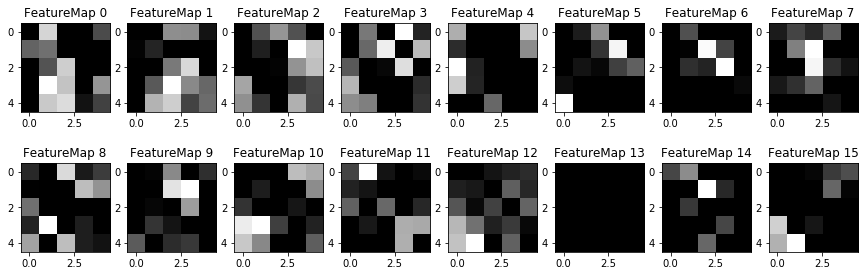

In [31]:
outputFeatureMap(images[0],conv2)